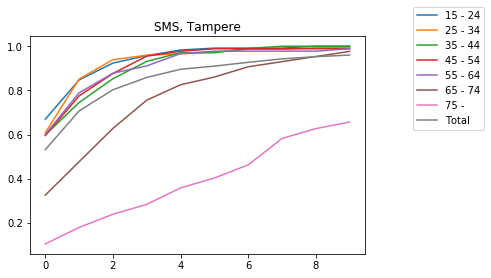

SMS, Tampere
    15 - 24   25 - 34   35 - 44   45 - 54   55 - 64   65 - 74      75 -  \
0  0.669492  0.608108  0.598039  0.595506  0.600000  0.325581  0.104478   
1  0.847458  0.851351  0.745098  0.775281  0.788889  0.476744  0.179104   
2  0.923729  0.939189  0.852941  0.876404  0.877778  0.627907  0.238806   
3  0.957627  0.959459  0.931373  0.955056  0.911111  0.755814  0.283582   
4  0.983051  0.966216  0.970588  0.977528  0.966667  0.825581  0.358209   
5  0.991525  0.972973  0.970588  0.988764  0.977778  0.860465  0.402985   
6  0.991525  0.986486  0.990196  0.988764  0.977778  0.906977  0.462687   
7  0.991525  0.986486  1.000000  0.988764  0.977778  0.930233  0.582090   
8  1.000000  0.993243  1.000000  0.988764  0.977778  0.953488  0.626866   
9  1.000000  0.993243  1.000000  0.988764  0.988889  0.976744  0.656716   

      Total  
0  0.531429  
1  0.707143  
2  0.802857  
3  0.858571  
4  0.895714  
5  0.910000  
6  0.927143  
7  0.942857  
8  0.952857  
9  0.960000  


In [21]:
import numpy as np
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def get_population(pop_size):
    df_finland = pd.read_csv('vaerak_001_201700.csv', sep=';')
    df_helsinki = pd.read_csv('vaerak_helsinki.csv', sep=';')
    df_tampere = pd.read_csv('vaerak_tampere.csv', sep=';')
    df_kajaani = pd.read_csv('vaerak_kajaani.csv', sep=';')
    df_inari = pd.read_csv('vaerak_inari.csv', sep=';')

    populations = [df_finland, df_helsinki, df_tampere, df_kajaani, df_inari]

    # Normalize populations to pop_size
    for frame in populations:
        normalize = 1.0/(frame['Population 2017'].sum())
        frame['Population 2017'] = frame['Population 2017'] * pop_size * normalize
        frame['Population 2017'] = frame['Population 2017'].apply(np.round).apply(np.int)

    populations = pd.concat(populations)
    return populations


def iterfunc(y):
    x = np.random.random()
    if x < y:
        return 1
    else:
        return 0


# Possile areas: 'Finland', 'Helsinki', 'Tampere', 'Kajaani', 'Inari'
# pop_size: integer
def simulate_radio(set_area, pop_size, steps):
    df_r = pd.read_csv('english_radio_listeninghours.csv')

    # Create propabilities from N(p0, p0/2) for whole population
    groups = []
    frames = []
    group_sizes = []
    populations = get_population(pop_size)
    for i in range(7):
        frame = populations.loc[populations.Area == set_area]
        n = frame.loc[i, 'Population 2017']
        age = frame.loc[i, 'Age']
        group_sizes.append(n)
        groups.append(np.random.normal(df_r.loc[i, 'Hours per week']/(24*7), df_r.loc[i, 'Hours per week']/(2*24*7), n))
        frames.append(pd.DataFrame({'probability' : groups[i], 'Age' : [age] * n}))

    df = pd.concat(frames, ignore_index=True)

    # limit propabilities #
    df.loc[df.probability < 0, 'probability'] = 0.0
    df.loc[df.probability > 0.5, 'probability'] = 0.5
    
    # Simulate #

    # Number of iterations
    # Interpretation: one iteration step corresponds to 1 min of broadcasted warning
#    steps = 10

    groups = df.Age.unique()

    pop = populations.loc[populations.Area == set_area]

    # The precentage of reached people is written in this DataFrame.
    results = pd.DataFrame()

    # Initialize 0 data frame for percentages
    # Create a column for each group
    for x in groups:
        results[x] = [0] * steps
    results['Total'] = [0] * steps

    # Iterations #

    # Who has been reached? A variable for each person
    df['reached'] = 0
    # A variable for remembering the previous step
    df['temp'] = 0

    # Simulations for radio
    for i in range(steps):
        df.temp = df.reached
        df.reached = df.probability.apply(iterfunc)
        df.loc[df.temp == 1, 'reached'] = 1
        for x in groups:
            z = pop.loc[pop.Age == x, 'Population 2017'].iloc[0]
            results.loc[i, x] = df.loc[df.Age == x, 'reached'].sum()/z
        results.loc[i, 'Total'] = df.reached.sum()/(pop['Population 2017'].sum())

    for x in results.columns:
        plt.plot(results[x], label=x)
        plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
    plt.title("Radio, " + str(set_area))
    plt.show()

    print("Radio, " + str(set_area))
    print(results)
#   results.to_csv('radio_results.csv')    


def simulate_tv(set_area, pop_size, steps):
    df_t = pd.read_csv('TV watched daily.csv')
    day = 60 * 24

    television_time = df_t.mean(axis=1)

    averages = []
    averages.append(television_time[1])
    averages.append(television_time[2])
    averages.append(television_time[2])
    averages.append(television_time[3])
    averages.append(television_time[3])
    averages.append(television_time[4])
    averages.append(television_time[4])

    populations = get_population(pop_size)
    groups = []
    frames = []
    for i in range(7):
        frame = populations.loc[populations.Area == set_area]
        n = frame.loc[i, 'Population 2017']
        age = frame.loc[i, 'Age']
        groups.append(np.random.normal(averages[i]/day, averages[i]/(2*day), n))
        frames.append(pd.DataFrame({'probability' : groups[i], 'Age' : [age] * n}))

    df = pd.concat(frames, ignore_index=True)

    # limit propabilities #
    df.loc[df.probability < 0, 'probability'] = 0.0
    df.loc[df.probability > 0.5, 'probability'] = 0.5

    # Simulate #

    # Number of iterations
    # Interpretation: one iteration step corresponds to 1 min of broadcasted warning
    # steps = 10

    groups = df.Age.unique()
    pop = populations.loc[populations.Area == set_area]

    # The precentage of reached people is written in this DataFrame.
    results = pd.DataFrame()

    # Initialize 0 data frame for percentages
    # Create a column for each group
    for x in groups:
        results[x] = [0] * steps
    results['Total'] = [0] * steps

    # Iterations #

    # Who has been reached? A variable for each person
    df['reached'] = 0
    # A variable for remembering the previous step
    df['temp'] = 0

    # Simulations for television
    for i in range(steps):
        df.temp = df.reached
        df.reached = df.probability.apply(iterfunc)
        df.loc[df.temp == 1, 'reached'] = 1
        for x in groups:
            z = pop.loc[pop.Age == x, 'Population 2017'].iloc[0]
            results.loc[i, x] = df.loc[df.Age == x, 'reached'].sum()/z
        results.loc[i, 'Total'] = df.reached.sum()/(pop['Population 2017'].sum())

    for x in results.columns:
        plt.plot(results[x], label=x)
        plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
    plt.title("Television, " + str(set_area))
    plt.show()
    
    print("Television, " + str(set_area))
    print(results)


def simulate_sms(set_area, pop_size, steps):
    # cellphone #
    phone1 = pd.read_csv('cellphone_usage.csv')

    phone = phone1[0:7]
    phone = phone.drop(columns='Used a cell phone in the last 3mos')

    populations = get_population(pop_size)
    # For those who own a cellphone:
    # Assume average of 8 h sleep and 6 h muted during day
    groups = []
    frames = []
    group_sizes = []
    for i in range(7):
        frame = populations.loc[populations.Area == set_area]
        n = frame.loc[i, 'Population 2017']
        age = frame.loc[i, 'Age']
        group_sizes.append(n)
        groups.append(np.random.normal(phone.loc[i, 'Owns a cellphone2)']*16/(24*100), phone.loc[i, 'Owns a cellphone2)']/(6*100), n))
        frames.append(pd.DataFrame({'propability' : groups[i], 'Age' : [age] * n}))

    df = pd.concat(frames, ignore_index=True)

    # limit propabilities #
    df.loc[df.propability < 0, 'propability'] = 0.0
    df.loc[df.propability > 1, 'propability'] = 1.0

    # Simulate #
    
    # Number of iterations
    # Interpretation: one iteration step corresponds ???
    #steps = 10

    groups = df.Age.unique()
    pop = populations.loc[populations.Area == set_area]

    # The precentage of reached people is written in this DataFrame.
    results = pd.DataFrame()

    # Initialize 0 data frame for percentages
    # Create a column for each group
    for x in groups:
        results[x] = [0] * steps
    results['Total'] = [0] * steps
    # Iterations #

    # Who has been reached? A variable for each person
    df['reached'] = 0
    # A variable for remembering the previous step
    df['temp'] = 0

    # Simulations for radio
    for i in range(steps):
        df.temp = df.reached
        df.reached = df.propability.apply(iterfunc)
        df.loc[df.temp == 1, 'reached'] = 1
        for x in groups:
            z = pop.loc[pop.Age == x, 'Population 2017'].iloc[0]
            results.loc[i, x] = df.loc[df.Age == x, 'reached'].sum()/z
        results.loc[i, 'Total'] = df.reached.sum()/(pop['Population 2017'].sum())
        
    for x in results.columns:
        plt.plot(results[x], label=x)
        plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
    plt.title("SMS, " + str(set_area))
    plt.show()
    #results.to_csv('phone_results.csv')

    print("SMS, " + str(set_area))
    print(results)


#simulate_sms('Tampere', 700, 10)

#simulate_tv('Kajaani', 700, 10)

#simulate_radio('Kajaani', 700, 10)
    


